In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time as ti
%matplotlib inline

In [3]:
def eval_triangle(x, h, n):
    """
    Compute triangle histogram for given latent variables
    Input:
        x [num_batch, num_latent] latent values
        h [num_latent, num_tri] triangle heights
        n [num_tri] number of triangles to use
    x is broadcasted to [num_batch, num_latent, num_tri] (replicated num_tri times)
    h is broadcasted to [num_batch, num_latent, num_tri] (replicated num_batch times)
    n is boradcasted to [num_batch, num_latent, num_tri] (replicated num_batch * num_latent times)
    Output:
        y [num_batch, num_latent, num_tri] evaluated triangles
    """
    h = tf.expand_dims(h, axis=0)
    x = tf.expand_dims(x, axis=-1)
    n = tf.expand_dims(tf.expand_dims(n, axis=0), axis=0)
    y = tf.nn.relu(h-tf.abs(x-n, name="abs_shifted"), name="tri_out")
    return y

In [4]:
def thetas(num_latent, num_tri):
    return tf.Variable(tf.ones((num_latent, num_tri)), name="thetas")

In [5]:
def weights(thetas):
    return tf.exp(thetas)

In [6]:
def zeta(thetas):
    """
    Normalizing constant
    Input:
        thetas [num_latent, num_tri]
    Output:
        zeta [num_latent]
    """
    return tf.reduce_sum(weights(thetas), axis=[1])

In [7]:
def prob_est(latent_vals, thetas, tri_locs):
    """
    Inputs:
        latent_vals [num_batch, num_latent] latent values
        thetas [num_latent, num_tri] triangle weights
        tri_locs [num_tri] location of each triangle for latent discretization
    Outputs:
        prob_est [num_batch, num_latent]
    """
    tris = eval_triangle(latent_vals, weights(thetas), tri_locs) # [num_batch, num_latent, num_tri]
    prob_est = tf.divide(tf.reduce_sum(tris, axis=[2]), tf.expand_dims(zeta(thetas), axis=0), name="prob_est")
    return prob_est

In [8]:
def log_likelihood(latent_vals, thetas, tri_locs):
    """
    Inputs:
        latent_vals [num_batch, num_latent] latent values
        thetas [num_latent, num_tri] triangle weights
        tri_locs [num_tri] location of each triangle for latent discretization
    Outputs:
        log_likelihood [num_latent]
    """
    probs = prob_est(latent_vals, weights(thetas), tri_locs) # [num_batch, num_latent]
    return tf.reduce_sum(tf.log(probs, name="log_probs"), axis=[0], name="log_likelihood")

In [9]:
def mle(log_likelihood, thetas, learning_rate):
  grads = tf.gradients(log_likelihood, thetas)[0]
  return thetas.assign_add(tf.multiply(tf.constant(learning_rate), grads))

In [10]:
num_batch = 100
num_latent = 30000
gauss_mean = 0
gauss_var = 10

# New free parameters
num_tris = 20
learning_rate = 0.01
num_mle = 10

with tf.device('/gpu:0'):
  x = tf.placeholder(tf.float32, shape=[num_batch, num_latent], name="latent_vals")
  n = tf.placeholder(tf.float32, shape=[num_tris], name="triangle_offset")
  tri_thetas = thetas(num_latent, num_tris)
  ll = log_likelihood(x, tri_thetas, n)

with tf.Session() as sess:
    sess.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))
    #latent_vals = np.random.normal(loc=gauss_mean, scale=gauss_var, size=[num_batch, num_latent])
    #latent_vals = np.random.poisson(lam=3, size=[num_batch, num_latent])
    latent_vals = np.random.laplace(loc=gauss_mean, scale=gauss_var, size=[num_batch, num_latent])
    tri_min = np.min(latent_vals)
    tri_max = np.max(latent_vals)
    tri_locs = np.linspace(tri_min, tri_max, num_tris)
    feed_dict={x:latent_vals, n:tri_locs}
    t0 = ti.time()
    for mle_step in range(num_mle):
        sess.run(mle(ll, tri_thetas, learning_rate), feed_dict) 
    t1 = ti.time()
    ll_eval, tri_eval = sess.run([ll, eval_triangle(x, tri_thetas, n)], feed_dict)
print(t1-t0, " seconds")



2.1477646827697754  seconds


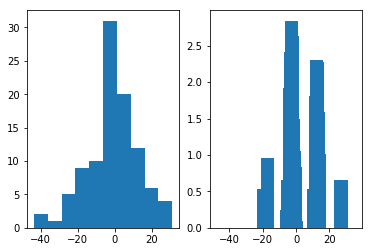

In [11]:
uid = np.random.choice(num_latent, 1)[0]
fig, axes = plt.subplots(1,2)
axes[0].hist(latent_vals[:, uid], bins=10)
axes[1].bar(latent_vals[:, uid], np.sum(tri_eval[:, uid, :], axis=1), width=8)
plt.show()

### To test:
* learn a set of triangle weights
* for given triangle weights, eval on large linspace
* output of tri_eval should match hist of original data